In [25]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from tqdm.notebook import tqdm

## Preparation

In [26]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

raw_train_set = ImageFolder("real_img", transform=transform)
BATCH_SIZE = 128

In [28]:
raw_train_set

Dataset ImageFolder
    Number of datapoints: 39209
    Root location: real_img
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [29]:
raw_train_set.class_to_idx

{'00000': 0,
 '00001': 1,
 '00002': 2,
 '00003': 3,
 '00004': 4,
 '00005': 5,
 '00006': 6,
 '00007': 7,
 '00008': 8,
 '00009': 9,
 '00010': 10,
 '00011': 11,
 '00012': 12,
 '00013': 13,
 '00014': 14,
 '00015': 15,
 '00016': 16,
 '00017': 17,
 '00018': 18,
 '00019': 19,
 '00020': 20,
 '00021': 21,
 '00022': 22,
 '00023': 23,
 '00024': 24,
 '00025': 25,
 '00026': 26,
 '00027': 27,
 '00028': 28,
 '00029': 29,
 '00030': 30,
 '00031': 31,
 '00032': 32,
 '00033': 33,
 '00034': 34,
 '00035': 35,
 '00036': 36,
 '00037': 37,
 '00038': 38,
 '00039': 39,
 '00040': 40,
 '00041': 41,
 '00042': 42}

In [30]:
def split_dataset(dataset, test_size, random_state):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=test_size, random_state=random_state)
    return Subset(dataset, train_idx), Subset(dataset, val_idx)


train_data, test_data = split_dataset(raw_train_set, 0.2, 42)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

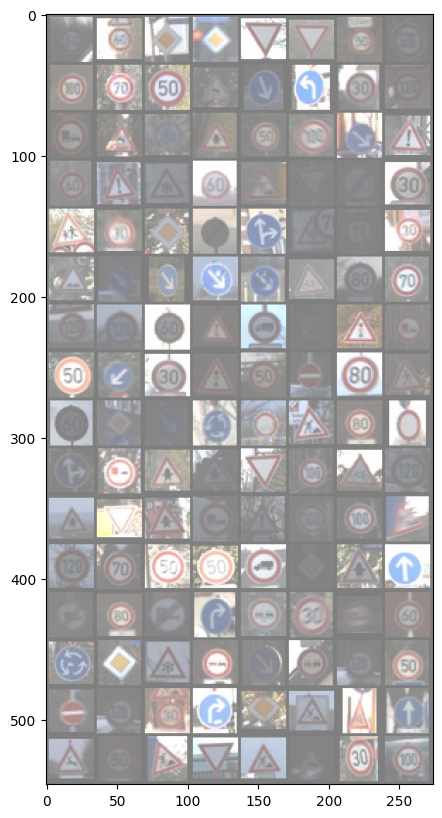

00003 00003 00012 00012 00013 00013 00002 00008 00007 00004 00002 00023 00038 00034 00001 00008 00010 00023 00040 00011 00002 00007 00038 00018 00003 00018 00030 00003 00025 00013 00006 00001 00028 00001 00012 00032 00036 00030 00004 00001 00022 00038 00038 00038 00038 00029 00005 00004 00008 00008 00003 00026 00016 00008 00026 00010 00002 00039 00001 00026 00002 00017 00005 00027 00003 00012 00038 00040 00015 00025 00005 00015 00036 00010 00011 00011 00013 00007 00029 00008 00011 00013 00011 00010 00018 00007 00007 00025 00008 00004 00002 00002 00016 00012 00011 00035 00042 00005 00042 00033 00009 00001 00010 00003 00040 00012 00030 00009 00038 00009 00008 00002 00017 00008 00001 00033 00012 00025 00029 00035 00031 00005 00025 00013 00025 00031 00001 00007


In [31]:
plt.figure(figsize=(20, 10))
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % raw_train_set.classes[labels[j]] for j in range(BATCH_SIZE)))

In [32]:
_, channels, dim1, dim2 = images[0:1].size()
channels, dim1, dim2

(3, 32, 32)

In [33]:
def train(model, optimizer, loss_function, num_epochs=30, train_loader=train_loader,
          test_loader=test_loader):
    for n in range(num_epochs):
        losses_epoch = []
        for x, _ in iter(train_loader):
            x = x.to(device)
            out, means, log_var = model(x)
            loss = loss_function(x, out, means, log_var)
            losses_epoch.append(loss.item())
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()
        L1_list = []
        #     if n % 10 == 0:
        for x, _ in iter(test_loader):
            x = x.to(device)
            out, _, _ = model(x)
            L1_list.append(torch.mean(torch.abs(out - x)).item())
        print(f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}")
        scheduler.step()

In [34]:
def visualize_reconstructions(model, input_imgs, device):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs, means, log_var = model(input_imgs.to(device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    # imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=False, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Reconstructions")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()


def generate_images(model, n_imgs, device):
    # Generate images
    model.eval()
    with torch.no_grad():
        generated_imgs = model.decoder(torch.randn([n_imgs, model.latent_dim]).to(device))
    generated_imgs = generated_imgs.cpu()

    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=False, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    if len(input_imgs) == 4:
        plt.figure(figsize=(10, 10))
    else:
        plt.figure(figsize=(15, 10))
    plt.title(f"Generations")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

## Basic VAE

In [35]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)  # encoder produces mean and log of variance
        #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, channels, dim1, dim2])
        return x_hat


class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

    def reparameterization(self, mean, var):
        # Change to proper
        epsilon = torch.randn(mean.shape).to(device)
        z = mean + epsilon * var
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))  # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [36]:
vae = VAE(latent_dim=32, hidden_dim=256, x_dim=dim1 * dim2 * channels).to(device)

optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

train(vae, optimizer, vae_loss_function, num_epochs=30)

Epoch 0 loss 16106.876668294271, test L1 = 0.11714840896667973
Epoch 1 loss 10514.246393467352, test L1 = 0.10051842658750472
Epoch 2 loss 9156.16688810519, test L1 = 0.0965404627063582
Epoch 3 loss 8558.226159568725, test L1 = 0.09040936214789268
Epoch 4 loss 8168.082213363027, test L1 = 0.08968202253022502
Epoch 5 loss 7937.225965050178, test L1 = 0.08730529645277608
Epoch 6 loss 7757.529387931513, test L1 = 0.08525087383966293
Epoch 7 loss 7638.9224180516185, test L1 = 0.0850080875379424
Epoch 8 loss 7507.710633192605, test L1 = 0.08388661869591282
Epoch 9 loss 7405.807300350531, test L1 = 0.08203236926947871
Epoch 10 loss 7326.952742041611, test L1 = 0.08181584698538627
Epoch 11 loss 7236.6397005406825, test L1 = 0.08090130708390667
Epoch 12 loss 7172.936005879224, test L1 = 0.0799656211128158
Epoch 13 loss 7108.221670259305, test L1 = 0.08011510751901134
Epoch 14 loss 7042.105850591892, test L1 = 0.07893988213712169
Epoch 15 loss 7006.735019342686, test L1 = 0.07845847873437789
Ep

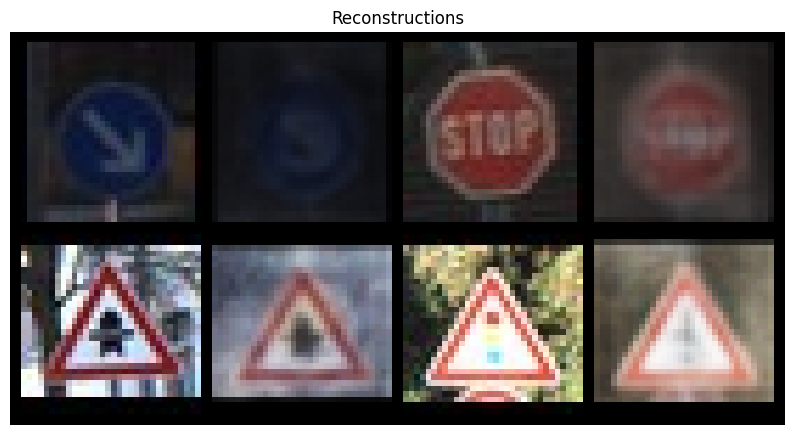

In [37]:
input_imgs, labels = next(iter(test_loader))
input_imgs = input_imgs[:4]
input_imgs.shape
visualize_reconstructions(vae, input_imgs, device)

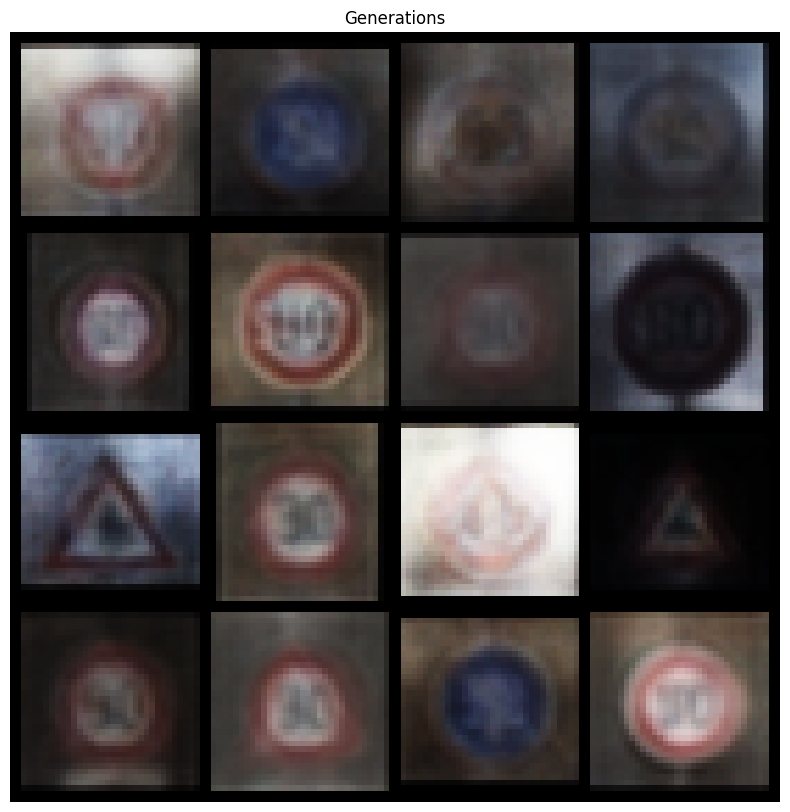

In [38]:
generate_images(vae, 16, device)

In [39]:
import os
from torchvision.utils import save_image

GENERATION_DIR = "generated_img"
if not os.path.exists(GENERATION_DIR):
    os.mkdir(GENERATION_DIR)

vae.eval()
with torch.no_grad():
    generated_imgs = vae.decoder(torch.randn([1000, vae.latent_dim]).to(device))
generated_imgs = generated_imgs.cpu()
for idx, img in enumerate(generated_imgs):
    path = os.path.join(GENERATION_DIR, f"{idx}.jpg")
    save_image(img, path)

Zaklęcie do oceny FID
```
python restructe.py # once
python peek_random_2000.py
python -m pytorch_fid generated_img real_flat_2000/  --device cuda:0
```

dla mini VAE 117
